# Goal
Make a physics-informed ELM using domain decomposition for the Helmholtz equation using jax.

The Helmholtz equation is:
\begin{equation}
\Delta u(x) + ku(x) = f(x) \quad  \forall x \in \Omega \\
u(x) = u_\mathrm{b}(x) \quad \forall x \in \Omega
\end{equation}


## Outline

Have an ELM for each subdomain, \
calculate a beta in each subdomain, \
calculate a (local/global?) residual and loss using the prediction from the sub-ELMs \
(later for Navier-Stokes: wrap the whole process in a LM optimization loop which iteratively optimizes the beta to minimize the loss/residuals)


### Plan

Domain Decomposition: 
- Choose a domain (x,y,t)
- For starters, place two RBFs in the domain, without any trainability
    - choose locations
    - make lambdas (exponential function, radius, center) covering the domain
- Initialize the sub-ELM for each lambda
    - use ELM() class that you already made
    - 



In [3]:
#!pip install jax
import jax
from jax import grad, jit, vmap, flatten_util
import jax.numpy as jnp
from jax.numpy.linalg import pinv 
import jax.scipy as jsp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
def activation_function(x):
    return jnp.tanh(x)

def loss(y, pred):
    return 0.5 * jnp.mean((y - pred) ** 2)

class ELM:
    def __init__(self, input_shape, num_hidden_neurons, output_shape):
        self.input_shape = input_shape
        self.num_hidden_neurons = num_hidden_neurons
        self.output_shape = output_shape
    
    #initialize H, W, b, and beta
    #first initialize W and b
        keys = jax.random.split(jax.random.PRNGKey(0), 3)
        self.w = jax.random.uniform(keys[0], minval = -1, maxval = 1, shape = (self.input_shape, self.num_hidden_neurons))
        self.b = jax.random.uniform(keys[1], minval = -1, maxval = 1, shape = (self.num_hidden_neurons,))
        self.beta = jax.random.uniform(keys[2], minval = -1, maxval = 1, shape = (self.num_hidden_neurons, self.output_shape))

    #make fit function
    @jit
    def fit(self, the_input, the_target):
        self.H = activation_function(the_input @ self.w + self.b)
        print(self.H.shape)
        self.beta = pinv(self.H) @ the_target
        #print('Done')
    
    #make prediction call
    def __call__(self, some_input):
        H = activation_function(some_input @ self.w + self.b)
        return H @ self.beta
    
    #calculate loss of prediciton
    def evaluate(self, some_input, some_target):
        pred = self(some_input)
        
        print(some_target.shape, pred.shape)
        
        error = loss(some_target, pred)
        
        return error
    
class HelmHELM:
    def __init__(self, input_shape, num_hidden_neurons, output_shape):
        self.input_shape = input_shape
        self.num_hidden_neurons = num_hidden_neurons
        self.output_shape = output_shape
    
    #initialize H, W, b, and beta
    #first initialize W and b
        keys = jax.random.split(jax.random.PRNGKey(0), 3)
        self.w = jax.random.uniform(keys[0], minval = -1, maxval = 1, shape = (self.input_shape, self.num_hidden_neurons))
        self.b = jax.random.uniform(keys[1], minval = -1, maxval = 1, shape = (self.num_hidden_neurons,))
        self.beta = jax.random.uniform(keys[2], minval = -1, maxval = 1, shape = (self.num_hidden_neurons, self.output_shape))

    #make fit function
    def fit(self, the_input, the_target):
        
        
        # make the hidden layer matrix
        
        self.H = activation_function(the_input @ self.w + self.b)
        print(self.H.shape)
        
        # calculate the derivative with respect to the input for each entry 
        
        
        
        
        self.beta = pinv(self.H) @ the_target
        
        
    
    #make prediction call
    def __call__(self, some_input):
        H = activation_function(some_input @ self.w + self.b)
        return H @ self.beta
    
    #calculate loss of prediciton
    def evaluate(self, some_input, some_target):
        pred = self(some_input)
        
        print(some_target.shape, pred.shape)
        
        error = loss(some_target, pred)
        
        return error
    
    

In [44]:
input_shape = 2
num_hidden_neurons = 4
output_shape = 1

def hvp(f, x, v):
    return jnp.vdot(grad(f, 0)(x), grad(f, 0)(x))

def extract_scalar(my_input, i):
    return jnp.tanh(my_input @ w + b)[i]

def activation_function(my_tuple):
    #tweener has shape (L,1); on every element we want to apply grad(grad(tanh))
    return [grad(lambda x: extract_scalar(x, i), 0)(my_tuple) for i in range(num_hidden_neurons)]
    #return hvp(jnp.tanh, my_tuple, jnp.ones_like(my_tuple))

my_input = jax.random.uniform(jax.random.PRNGKey(200), minval = -1, maxval = 1, shape = (10,2))

keys = jax.random.split(jax.random.PRNGKey(0), 3)
w = jax.random.uniform(keys[0], minval = -1, maxval = 1, shape = (input_shape, num_hidden_neurons))
b = jax.random.uniform(keys[1], minval = -1, maxval = 1, shape = (num_hidden_neurons,))
beta = jax.random.uniform(keys[2], minval = -1, maxval = 1, shape = (num_hidden_neurons, output_shape))

print('Shapes: ', '\n', 'input: ', my_input.shape, '\n', 'w: ', w.shape, '\n', 'b: ', b.shape, '\n', 'beta: ', beta.shape)
print('Activation function input shape: ', (my_input[0] @ w + b).shape)

print(extract_scalar(my_input[0], 0))
print(activation_function(my_input[0]))


Shapes:  
 input:  (10, 2) 
 w:  (2, 4) 
 b:  (4,) 
 beta:  (4, 1)
Activation function input shape:  (4,)
0.37510553


TypeError: differentiating with respect to argnums=1 requires at least 2 positional arguments to be passed by the caller, but got only 1 positional arguments.

In [18]:
myELM = ELM(2, 16, 1)
some_input = jax.random.uniform(jax.random.PRNGKey(200), minval = -1, maxval = 1, shape = (200,2))

[[-2.4835823e+00]
 [-5.6798148e-01]
 [-1.3073362e+00]
 [-1.5937946e+00]
 [-1.5280036e+00]
 [-2.1993241e+00]
 [-2.2025790e+00]
 [ 3.5481513e-01]
 [-1.9085388e+00]
 [-2.5920589e+00]
 [-2.5900593e+00]
 [-8.4638494e-01]
 [-2.0313950e+00]
 [-1.9350042e+00]
 [-2.2267210e-01]
 [-9.0207577e-01]
 [-3.8854194e-01]
 [-2.5236223e+00]
 [-2.0900946e+00]
 [-1.2229543e+00]
 [-1.1774406e+00]
 [ 8.4297061e-02]
 [-2.2362227e+00]
 [-5.6785667e-01]
 [-1.3770840e+00]
 [-1.4760361e+00]
 [ 4.4116294e-01]
 [ 6.9887161e-01]
 [-1.4176100e+00]
 [-2.2769041e+00]
 [-2.6973240e+00]
 [-8.8954449e-02]
 [-7.4132127e-01]
 [-1.6630259e+00]
 [-8.1443042e-01]
 [-4.6964383e-01]
 [-2.5378554e+00]
 [ 8.6631525e-01]
 [-1.0320116e+00]
 [-1.6783221e+00]
 [-8.3630061e-01]
 [-1.7447360e+00]
 [-4.1954345e-01]
 [-2.1761515e+00]
 [-2.5361748e+00]
 [-9.8563552e-01]
 [-1.7781636e+00]
 [-8.4682083e-01]
 [-2.3667278e+00]
 [-2.5740914e+00]
 [-1.7353098e+00]
 [-1.7353859e+00]
 [-1.7106283e+00]
 [-3.0142975e-01]
 [-2.3399992e+00]
 [-2.29417

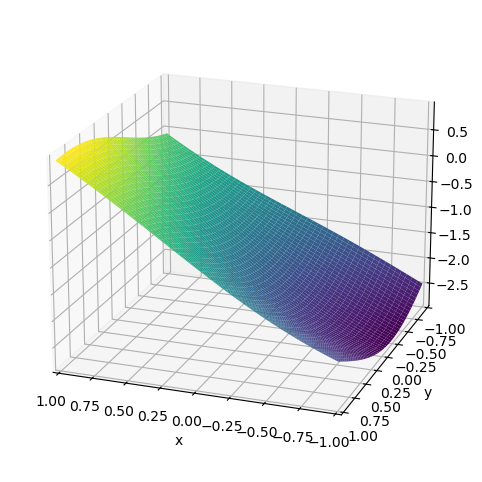

In [23]:
new_x = np.linspace(-1, 1, 100)
new_y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(new_x, new_y)

def plot2D_my_approx():
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, myELM(jnp.stack([X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1)], axis = -1)).reshape((100, 100)),  cmap=cm.viridis)
    #ax.scatter(some_input[:,0], some_input[:,1], , color = 'tab:red', alpha = 2**(-0.0005*N))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.view_init(20, 110)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
plot2D_my_approx()